<a href="https://colab.research.google.com/github/simorxb/Neuromancer-Pendulum-Control/blob/main/Pendulum-Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install (Colab only)**

Skip this step when running locally.

In [1]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

  Cloning https://github.com/pnnl/neuromancer.git (to revision master) to /tmp/pip-install-clcvzslg/neuromancer_a5422f9d1a804a46b765ffc3adaee2c1
  Running command git clone --filter=blob:none --quiet https://github.com/pnnl/neuromancer.git /tmp/pip-install-clcvzslg/neuromancer_a5422f9d1a804a46b765ffc3adaee2c1
  Resolved https://github.com/pnnl/neuromancer.git to commit 662ac066e5be80a8877894ed1ed6e46e7e0ad34d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 MB 9.0 MB/s eta 0:00:00
     ━━━━

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import argparse
from torch.utils.data import DataLoader
import os
import numpy as np
import math

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.dynamics.ode import ODESystem
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.psl import plot
from neuromancer import psl
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.plot import pltCL, pltPhase

torch.manual_seed(0)

## System model - Pendulum

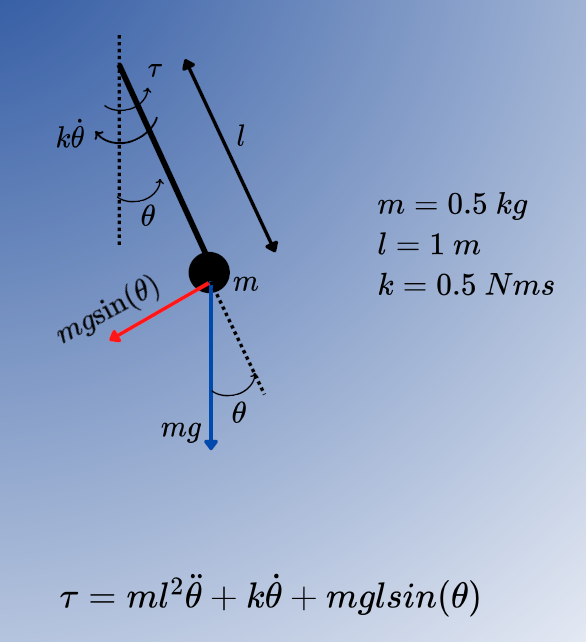

In [3]:
# Define a subclass of ODESystem to implement the pendulum equations - white box model
class Pendulum(ODESystem):

    def __init__(self, insize=3, outsize=2):
        """

        :param insize:
        :param outsize:
        """
        super().__init__(insize=insize, outsize=outsize)
        self.m = nn.Parameter(torch.tensor([0.5]), requires_grad=False) # Mass
        self.l = nn.Parameter(torch.tensor([1.0]), requires_grad=False) # Length
        self.k = nn.Parameter(torch.tensor([0.5]), requires_grad=False) # Damping coefficient

    def ode_equations(self, x, u):
        x1 = x[:, [0]] # theta
        x2 = x[:, [1]] #theta_dot
        dx1 = x2
        dx2 = (u[:, [0]] - self.k * x2 - self.m * 9.81 * self.l * torch.sin(x1))/(self.m * self.l**2)
        return torch.cat([dx1, dx2], dim=-1)




## Training dataset generation

For a training dataset we randomly sample initial conditions of states and sequence of admissible reference trajectories over predefined prediction horizon from given distributions $\mathcal{P}_{x_0}$, and $\mathcal{P}_R$, respectively.

In [10]:
nsteps = 30  # prediction horizon
n_samples = 2000    # number of sampled scenarios

nx = 2 # number of states
nref = 1 # number of reference signals
nu = 1 # number of control inputs

theta_min = 0.0
theta_max = 2*math.pi

#  sampled references for training the policy
list_refs = [theta_min + (theta_max - theta_min)*torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
ref = torch.cat(list_refs)
batched_ref = ref.reshape([n_samples, nsteps+1, nref])
# Training dataset
train_data = DictDataset({'x': theta_min + (theta_max - theta_min)*torch.rand(n_samples, 1, nx),   # sampled initial conditions of states
                          'r': batched_ref}, name='train')

# sampled references for development set
list_refs = [theta_min + (theta_max - theta_min)*torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
ref = torch.cat(list_refs)
batched_ref = ref.reshape([n_samples, nsteps+1, nref])
# Development dataset
dev_data = DictDataset({'x': theta_min + (theta_max - theta_min)*torch.rand(n_samples, 1, nx),    # sampled initial conditions of states
                        'r': batched_ref}, name='dev')

# torch dataloaders
batch_size = 200
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                         collate_fn=dev_data.collate_fn,
                                         shuffle=False)

## System model and Control policy in Neuromancer

Here we construct a closed-loop system as differentiable computational graph by coinnecting the system dynamics model  $x_{k+1} = \text{ODESolve}(f(x_k, u_k))$ with neural control policy $u_k = \pi_{\theta}(x_k, R)$. Hence we obtain a trainable system architecture:
$x_{k+1} = \text{ODESolve}(f(x_k, \pi_{\theta}(x_k, R)))$.

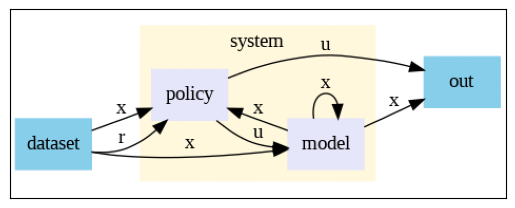

In [11]:
ts = 0.1 # sample time

umin = -7.0 # Minimum torque
umax = 7.0 # Maximum torque

# Create instance of Pendulum
pendulum = Pendulum()

# integrate continuous time ODE
integrator = integrators.RK4(pendulum, h=torch.tensor(ts))   # using 4th order runge kutta integrator
# symbolic system model
model = Node(integrator, ['x', 'u'], ['x'], name='model')

# neural net control policy with hard control action bounds
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy = Node(net, ['x', 'r'], ['u'], name='policy')

# closed-loop system model
cl_system = System([policy, model], nsteps=nsteps)
cl_system.show()

## Differentiable Predictive Control objectives and constraints

Here we take advantage of Neuromancer's high level symbolic language to define objective and constraint terms of our optimal control problem.

In [12]:
# variables
x = variable('x')
ref = variable('r')
# objectives
regulation_loss = 5. * ((x[:, :, [0]] == ref) ^ 2)  # target posistion (theta)
# constraints
terminal_lower_bound_penalty = 10.*(x[:, [-1], [0]] > ref[:, [-1], [0]]-0.01)
terminal_upper_bound_penalty = 10.*(x[:, [-1], [0]] < ref[:, [-1], [0]]+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'regulation_loss'
terminal_lower_bound_penalty.name = 'theta_N_min'
terminal_upper_bound_penalty.name = 'theta_N_max'
# list of constraints and objectives
objectives = [regulation_loss]
constraints = [terminal_lower_bound_penalty, terminal_upper_bound_penalty]

## Differentiable optimal control problem

Here we put things together to construct a differentibale optimal control problem.

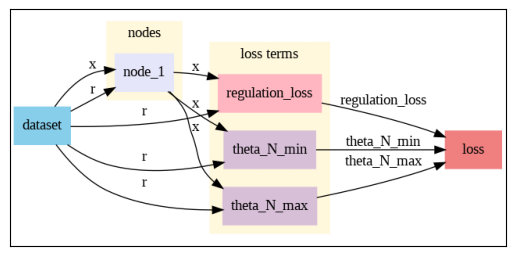

In [13]:
# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [cl_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
problem.show()

## Solve the problem

We solve the problem using stochastic gradient descent over pre-defined training data of sampled parameters.

In [14]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=0.002)
#  Neuromancer trainer
trainer = Trainer(
    problem,
    train_loader, dev_loader,
    optimizer=optimizer,
    epochs=100,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=50,
)
# Train control policy
best_model = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_model)


epoch: 0  train_loss: 84.42140197753906
epoch: 1  train_loss: 67.33321380615234
epoch: 2  train_loss: 41.314292907714844
epoch: 3  train_loss: 22.66825294494629
epoch: 4  train_loss: 17.6018123626709
epoch: 5  train_loss: 14.974649429321289
epoch: 6  train_loss: 13.477157592773438
epoch: 7  train_loss: 12.585270881652832
epoch: 8  train_loss: 11.98979663848877
epoch: 9  train_loss: 11.590970993041992
epoch: 10  train_loss: 11.330205917358398
epoch: 11  train_loss: 11.167201042175293
epoch: 12  train_loss: 11.057564735412598
epoch: 13  train_loss: 10.97348403930664
epoch: 14  train_loss: 10.89793586730957
epoch: 15  train_loss: 10.827252388000488
epoch: 16  train_loss: 10.759627342224121
epoch: 17  train_loss: 10.692940711975098
epoch: 18  train_loss: 10.62755012512207
epoch: 19  train_loss: 10.562759399414062
epoch: 20  train_loss: 10.497751235961914
epoch: 21  train_loss: 10.432367324829102
epoch: 22  train_loss: 10.362772941589355
epoch: 23  train_loss: 10.291769027709961
epoch: 24  

<All keys matched successfully>

# Evaluate best model on a system rollout


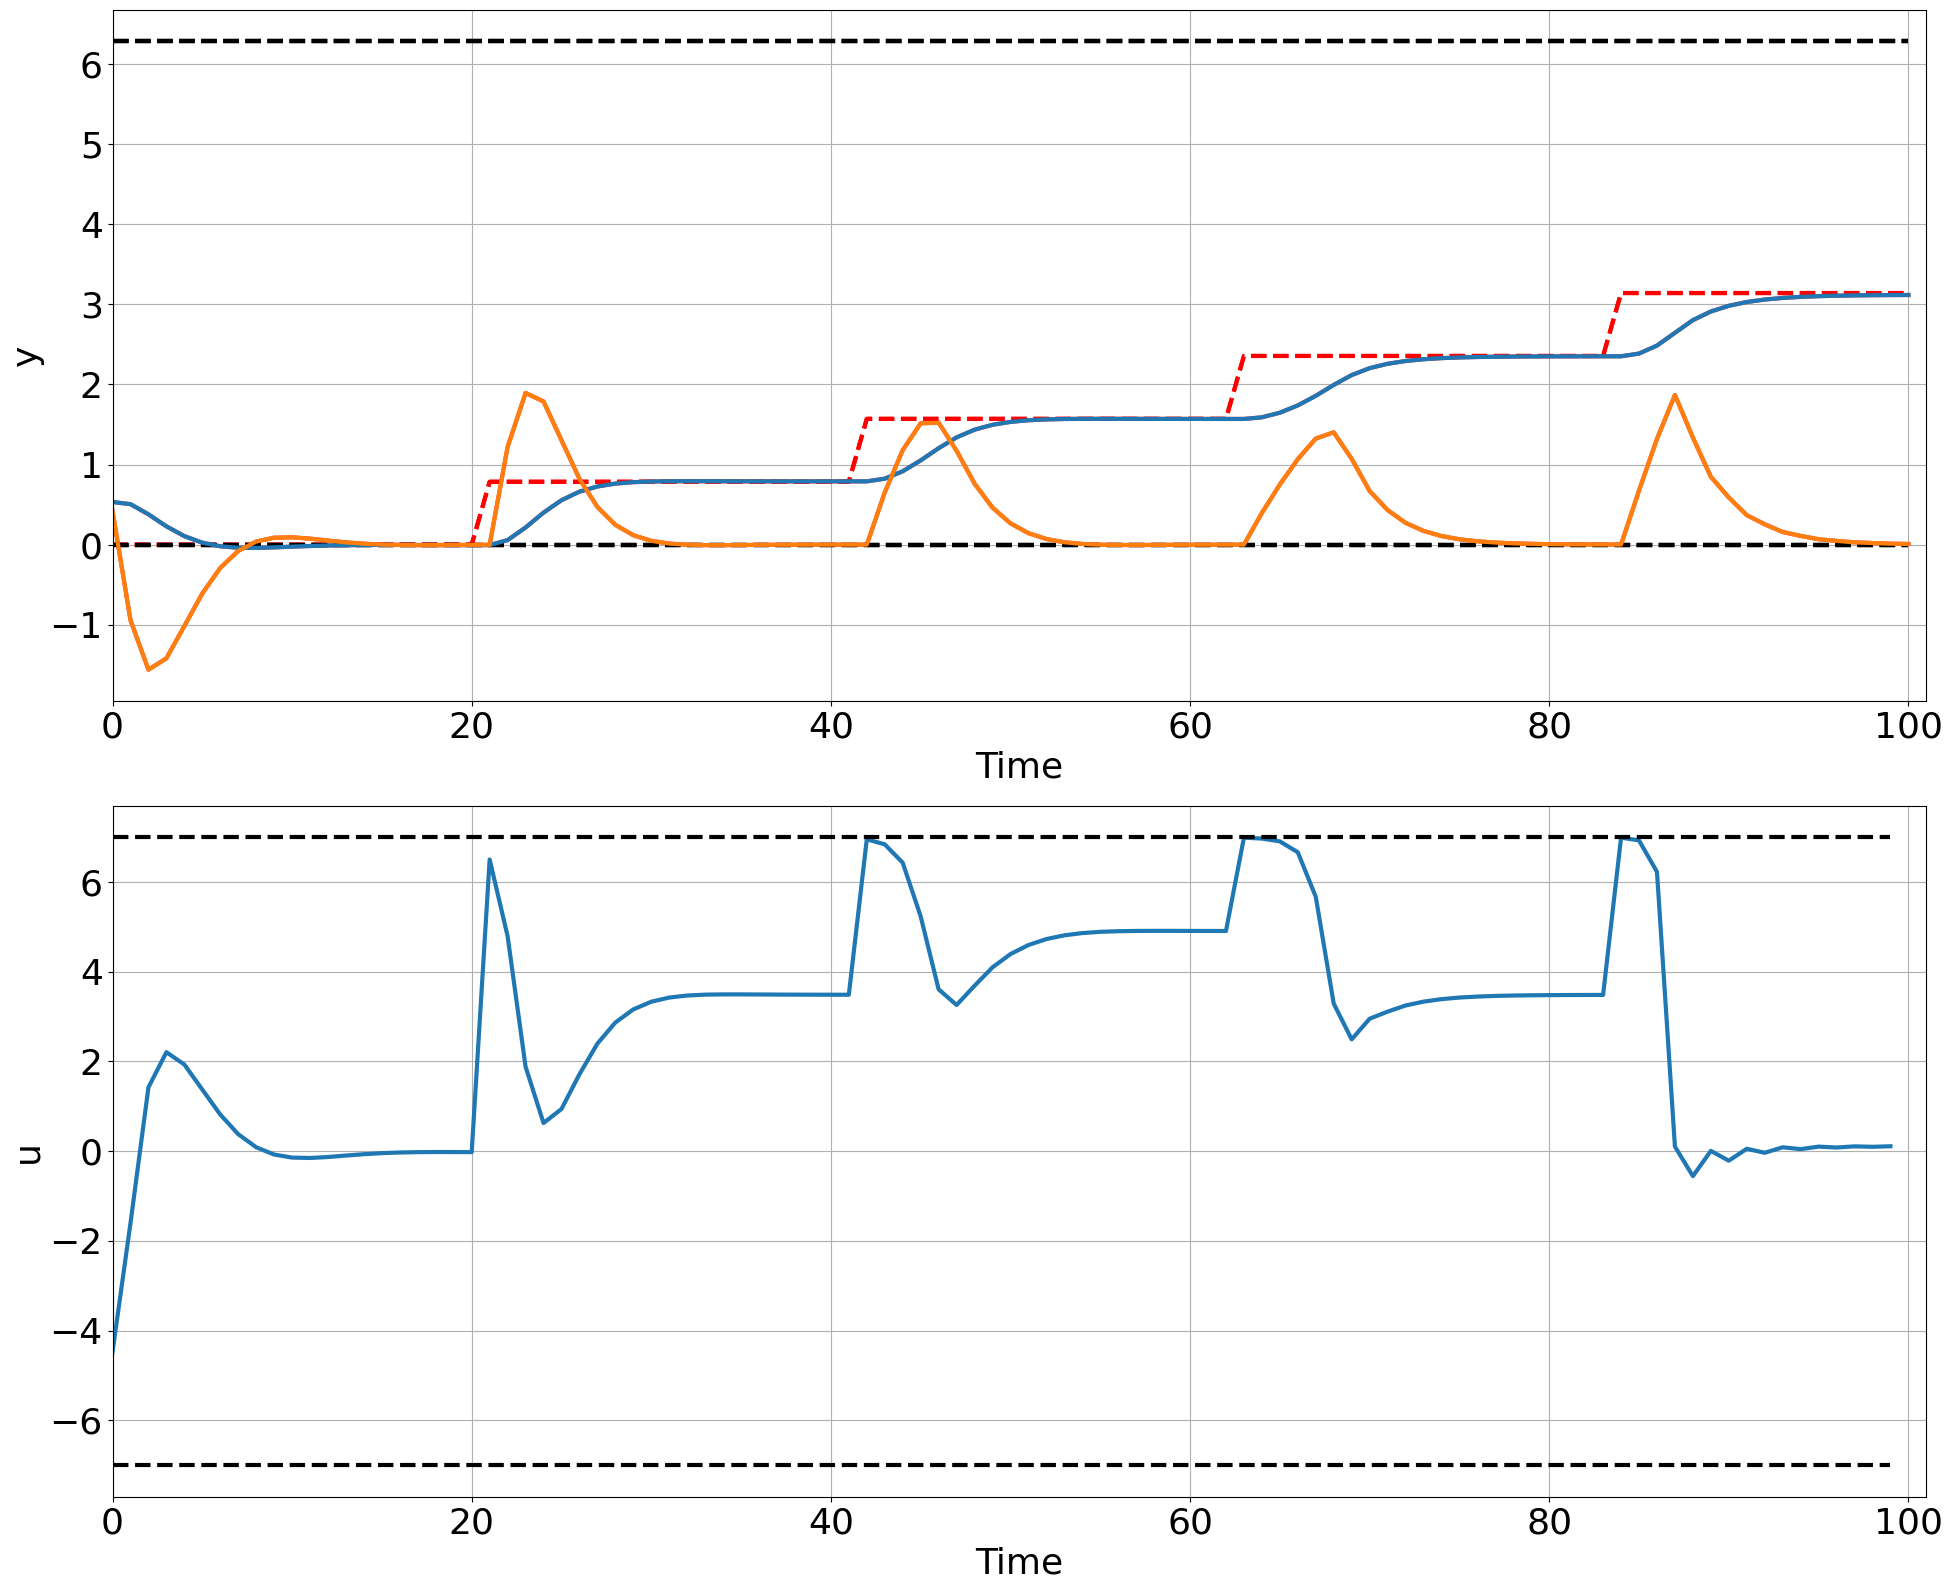

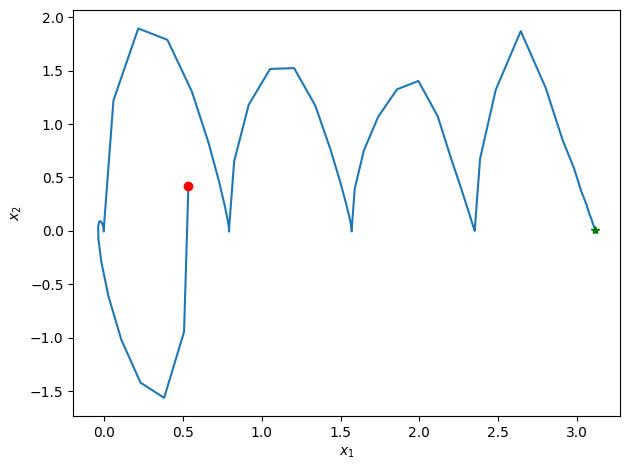

<Figure size 640x480 with 0 Axes>

In [16]:
nsteps = 100 # 10 seconds
step_length = 20 # 2 seconds
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=theta_min, max=theta_max, values=[0.0, math.pi/4, math.pi/2, 3*math.pi/4, math.pi])
torch_ref = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
# generate initial data for closed loop simulation
data = {'x': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}
cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)




#Plot results

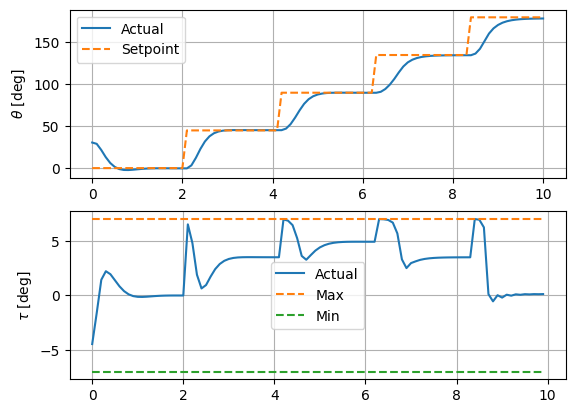

In [38]:
time_points = np.arange(0, nsteps+1, 1)*ts
# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])

# Create figure
plt.figure()

# Plot response
plt.subplot(2, 1, 1)
plt.plot(time_points, trajectories['x'].detach().reshape(nsteps + 1, nx)[:,0]*180/math.pi, label="Actual")
plt.plot(time_points, trajectories['r'].detach().reshape(nsteps + 1, nref)*180/math.pi, "--", label="Setpoint")
plt.ylabel(r"$\theta$ [deg]")
plt.legend()
plt.grid()

# Plot control input
plt.subplot(2, 1, 2)
plt.plot(time_points[0:-1], trajectories['u'].detach().reshape(nsteps, nu), label="Actual")
plt.plot(time_points[0:-1], Umax, "--", label="Max")
plt.plot(time_points[0:-1], Umin, "--", label="Min")
plt.ylabel(r"$\tau$ [deg]")
plt.legend()
plt.grid()

# Show plots
plt.show()